# LSTM Model Training for Stock Price Forecasting

This notebook trains an LSTM model using PyTorch to forecast close returns for all stocks in the TQBR dataset.

## Architecture
- **Modular design**: Separate classes for Dataset, Model, and Trainer for easy extension
- **Target**: Close Return (percentage change in Close price)
- **Training & Validation**: Proper train/val split with metrics tracking


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/DeepGap')

In [3]:
# Imports
import os
import glob
import warnings
from pathlib import Path
from typing import List, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


## Configuration


In [4]:
# Configuration
class Config:
    # Data paths
    DATA_DIR = "data/tqbr"

    # Model hyperparameters
    SEQUENCE_LENGTH = 60  # Number of days to look back
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.2
    BIDIRECTIONAL = False

    # Training hyperparameters
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 50
    EARLY_STOPPING_PATIENCE = 10
    VALIDATION_SPLIT = 0.2

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model save path
    MODEL_SAVE_DIR = "models"
    MODEL_NAME = "lstm_close_return_model.pth"

config = Config()
print(f"Using device: {config.DEVICE}")


Using device: cuda


## Data Loading and Preprocessing


In [5]:
def load_all_stock_data(data_dir: str) -> pd.DataFrame:
    """
    Load all CSV files from the data directory and combine them.
    Returns a DataFrame with columns: ticker, Date, Close, Close_Return
    """
    all_data = []
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

    print(f"Found {len(csv_files)} CSV files")

    for file_path in csv_files:
        ticker = Path(file_path).stem
        try:
            df = pd.read_csv(file_path)
            if 'Date' in df.columns and 'Close' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.sort_values('Date')

                # Calculate Close Return (percentage change * 100)
                df['Close_Return'] = df['Close'].pct_change() * 100

                # Add ticker column
                df['Ticker'] = ticker

                # Keep only necessary columns
                df = df[['Ticker', 'Date', 'Close', 'Close_Return']].copy()

                # Drop first row (NaN from pct_change)
                df = df.dropna().reset_index(drop=True)

                if len(df) > config.SEQUENCE_LENGTH:  # Only keep stocks with enough data
                    all_data.append(df)
        except Exception as e:
            print(f"Error loading {ticker}: {e}")
            continue

    if not all_data:
        raise ValueError("No data loaded!")

    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Total records: {len(combined_df)}")
    print(f"Unique tickers: {combined_df['Ticker'].nunique()}")
    print(f"Date range: {combined_df['Date'].min()} to {combined_df['Date'].max()}")

    return combined_df

# Load data
df_all = load_all_stock_data(config.DATA_DIR)
df_all.head()

Found 258 CSV files
Total records: 554141
Unique tickers: 254
Date range: 2013-03-26 00:00:00 to 2025-10-10 00:00:00


,Ticker,Date,Close,Close_Return
0,ALRS,2013-09-03,33.198,0.600000
1,ALRS,2013-09-04,33.327,0.388578
2,ALRS,2013-09-05,33.340,0.039007
3,ALRS,2013-09-06,33.061,-0.836833
4,ALRS,2013-09-09,33.299,0.719881


In [6]:
df_all.sample(20)

,Ticker,Date,Close,Close_Return
362456,RGSS,2025-02-13,0.2270,0.265018
310549,NMTP,2025-08-28,8.7550,-0.398180
28863,ASSB,2017-11-14,0.4800,3.896104
325335,OMZZP,2019-08-07,3425.0000,2.238806
160168,KRKN,2021-04-01,14200.0000,-1.045296
173089,KRSB,2021-03-17,9.8200,0.924974
510399,VJGZ,2022-08-23,1207.0000,0.583333
5388,ABRD,2022-11-14,183.0000,1.666667
171383,KROTP,2024-07-11,715.0000,2.142857
32024,BANE,2019-04-11,1972.0000,-0.328532


In [7]:
# clip garbage
df_all['Close_Return'] = np.clip(df_all.Close_Return.to_numpy(), -20.0, 20.0)

In [8]:
## Load and Process Sentiment Data

# Load all sentiment CSV files
def load_sentiment_data(sentiment_dir: str) -> pd.DataFrame:
    """
    Load all sentiment CSV files and extract relevant information.
    Returns a DataFrame with Ticker, Date and sentiment score (prob_positive - prob_negative)
    """
    all_sentiment = []
    sentiment_files = glob.glob(os.path.join(sentiment_dir, "*_sentiment.csv"))

    print(f"Found {len(sentiment_files)} sentiment files")

    for file_path in sentiment_files:
        try:
            # Extract ticker from filename
            ticker = os.path.basename(file_path).split('_sentiment.csv')[0]

            df_sent = pd.read_csv(file_path)

            # Parse published date
            df_sent['Date'] = pd.to_datetime(df_sent['published'], errors='coerce', utc=True)
            df_sent = df_sent.dropna(subset=['Date'])

            # Extract date only (remove time component)
            df_sent['Date'] = df_sent['Date'].dt.date

            # Calculate sentiment score: prob_positive - prob_negative
            df_sent['Sentiment'] = df_sent['prob_positive'] - df_sent['prob_negative']

            # Add ticker column
            df_sent['Ticker'] = ticker

            # Keep only necessary columns
            df_sent = df_sent[['Ticker', 'Date', 'Sentiment']].copy()

            all_sentiment.append(df_sent)
        except Exception as e:
            print(f"Error loading sentiment file {file_path}: {e}")
            continue

    if not all_sentiment:
        raise ValueError("No sentiment data loaded!")

    combined_sentiment = pd.concat(all_sentiment, ignore_index=True)
    print(f"Total sentiment events: {len(combined_sentiment)}")
    print(f"Date range: {combined_sentiment['Date'].min()} to {combined_sentiment['Date'].max()}")
    print(f"Unique tickers in sentiment data: {combined_sentiment['Ticker'].nunique()}")

    return combined_sentiment

# Load sentiment data
SENTIMENT_DIR = "data/sentiment"
sentiment_df = load_sentiment_data(SENTIMENT_DIR)
sentiment_df.head()

Found 30 sentiment files
Total sentiment events: 6441
Date range: 2015-01-19 to 2025-12-12
Unique tickers in sentiment data: 30


,Ticker,Date,Sentiment
0,ROSN,2015-02-16,0.074701
1,ROSN,2015-04-07,-0.124875
2,ROSN,2015-05-05,0.948803
3,ROSN,2015-10-16,0.942863
4,ROSN,2016-05-17,-0.511070


In [9]:
# Lambda parameter: such that sentiment halves over a month (30 days)

# # exp(-lambda * 30) = 0.5  =>  lambda = ln(2) / 30
# LAMBDA = np.log(2) / 30
# exp(-lambda * 30) = 0.1  =>  lambda = ln(10) / 30
LAMBDA = np.log(10) / 30

print(f"Lambda (decay constant): {LAMBDA:.6f}")
print(f"Verification: exp(-lambda * 30) = {np.exp(-LAMBDA * 30):.6f} (should be ~0.5)")

def calculate_company_sentiment_vectorized(price_df: pd.DataFrame, sentiment_df: pd.DataFrame, lambda_decay: float) -> pd.DataFrame:
    """
    Calculate company-specific sentiment for each day in price_df using a vectorized approach.
    Formula: sentiment = sum([prob_positive - prob_negative] * exp(-lambda * dt))
    where dt is days from event to current day, only summing events prior to current day.

    Args:
        price_df: DataFrame with Ticker and Date columns
        sentiment_df: DataFrame with Ticker, Date and Sentiment columns
        lambda_decay: Decay constant lambda

    Returns:
        DataFrame with Ticker, Date and Company_Sentiment columns
    """
    # Convert dates to datetime for easier manipulation
    price_df = price_df.copy()
    price_df['Date'] = pd.to_datetime(price_df['Date']).dt.date

    sentiment_df = sentiment_df.copy()
    sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.date

    # Sort by date
    price_df = price_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    sentiment_df = sentiment_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

    # Get unique tickers from price data
    unique_tickers = price_df['Ticker'].unique()

    company_sentiments = []

    # Process each ticker separately
    for ticker in unique_tickers:
        # Get price dates for this ticker
        ticker_prices = price_df[price_df['Ticker'] == ticker].copy()
        price_dates = ticker_prices['Date'].values

        # Get sentiment events for this ticker
        ticker_sentiments = sentiment_df[sentiment_df['Ticker'] == ticker].copy()

        if len(ticker_sentiments) == 0:
            # # No sentiment data for this ticker, set all to 0
            # for date in price_dates:
            #     company_sentiments.append({
            #         'Ticker': ticker,
            #         'Date': date,
            #         'Company_Sentiment': 0.0
            #     })

            # update: skip companies for which there is no sentiment data entirely

            continue

        sentiment_dates = ticker_sentiments['Date'].values
        sentiment_values = ticker_sentiments['Sentiment'].values

        # --- FIX IS HERE ---
        # Create a matrix of time differences (days) between each price date and each sentiment date
        # Shape: (len(price_dates), len(sentiment_dates))

        # Convert date objects to numpy datetime64[D] for vectorized calculation
        price_dates_np = np.array(price_dates, dtype='datetime64[D]')
        sentiment_dates_np = np.array(sentiment_dates, dtype='datetime64[D]')

        # Calculate the difference in days for all combinations
        # price_dates_np[:, None] makes it a column vector for broadcasting
        time_diff_matrix = (price_dates_np[:, None] - sentiment_dates_np).astype(int)
        # --- END OF FIX ---

        # Create a mask for events that occurred before each price date
        mask = time_diff_matrix >= 0

        # Calculate decay factors for all time differences
        decay_factors = np.exp(-lambda_decay * time_diff_matrix)

        # Apply mask to zero out future events
        decay_factors[~mask] = 0

        # Calculate sentiment for each price date
        # This is a vectorized dot product: sum(sentiment * decay_factor) for each price date
        company_sentiment_values = np.dot(decay_factors, sentiment_values)

        # Create result entries for this ticker
        for i, date in enumerate(price_dates):
            company_sentiments.append({
                'Ticker': ticker,
                'Date': date,
                'Company_Sentiment': company_sentiment_values[i]
            })

    company_sentiment_df = pd.DataFrame(company_sentiments)
    return company_sentiment_df

# Calculate company sentiment for each day using the vectorized approach
company_sentiment_df = calculate_company_sentiment_vectorized(df_all, sentiment_df, LAMBDA)
print(f"\nCompany sentiment calculated for {len(company_sentiment_df)} ticker-date pairs")
print(f"Company sentiment statistics:")
print(company_sentiment_df['Company_Sentiment'].describe())
print("\nFirst few rows:")
print(company_sentiment_df.head(10))

Lambda (decay constant): 0.076753
Verification: exp(-lambda * 30) = 0.100000 (should be ~0.5)

Company sentiment calculated for 77477 ticker-date pairs
Company sentiment statistics:
count    7.747700e+04
mean     1.195714e-01
std      4.841078e-01
min     -5.599543e+00
25%     -7.765480e-18
50%      1.360262e-10
75%      6.384310e-02
max      5.717742e+00
Name: Company_Sentiment, dtype: float64

First few rows:
  Ticker        Date  Company_Sentiment
0   AFKS  2014-06-10                0.0
1   AFKS  2014-06-11                0.0
2   AFKS  2014-06-16                0.0
3   AFKS  2014-06-17                0.0
4   AFKS  2014-06-18                0.0
5   AFKS  2014-06-19                0.0
6   AFKS  2014-06-20                0.0
7   AFKS  2014-06-23                0.0
8   AFKS  2014-06-24                0.0
9   AFKS  2014-06-25                0.0


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        2.0000e+00, 3.0000e+00, 3.0000e+00, 5.0000e+00, 2.0000e+00,
        7.0000e+00, 5.0000e+00, 7.0000e+00, 9.0000e+00, 1.3000e+01,
        1.9000e+01, 2.5000e+01, 2.1000e+01, 3.0000e+01, 4.9000e+01,
        6.6000e+01, 6.5000e+01, 6.6000e+01, 9.6000e+01, 1.1900e+02,
        1.5800e+02, 2.2100e+02, 2.7000e+02, 4.1100e+02, 5.7500e+02,
        7.0300e+02, 1.0160e+03, 1.4510e+03, 2.5270e+03, 4.9887e+04,
        4.3340e+03, 2.7650e+03, 2.1960e+03, 1.7360e+03, 1.4240e+03,
        1.2060e+03, 1.0090e+03, 8.3700e+02, 6.7000e+02, 5.2800e+02,
        4.5400e+02, 3.7900e+02, 3.2200e+02, 2.7900e+02, 2.3000e+02,
        1.9000e+02, 1.6100e+02, 1.4200e+02, 1.1600e+02, 9.0000e+01,
        8.1000e+01, 7.2000e+01, 4.8000e+01, 5.60

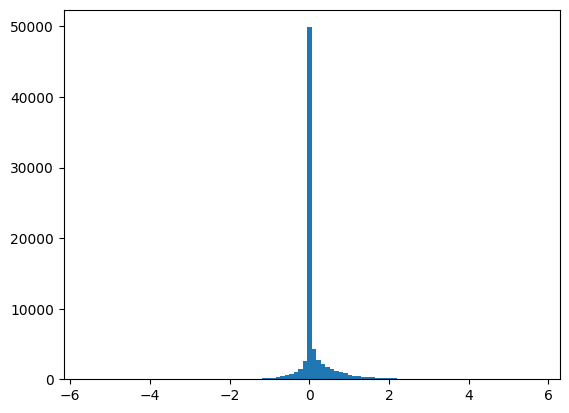

In [10]:
plt.hist(company_sentiment_df.Company_Sentiment, bins=100)

In [11]:
company_sentiment_df.Ticker.unique()

array(['AFKS', 'AFLT', 'ALRS', 'BELU', 'CBOM', 'CHMF', 'FESH', 'GAZP',
       'GMKN', 'HYDR', 'IRKT', 'MAGN', 'MGNT', 'MOEX', 'MTSS', 'MVID',
       'NLMK', 'OZON', 'PHOR', 'PLZL', 'POSI', 'ROSN', 'RTKM', 'RUAL',
       'SBER', 'SNGSP', 'TATN', 'VTBR'], dtype=object)

In [12]:
company_sentiment_df.loc[company_sentiment_df.Company_Sentiment != 0.0, :].head(10)

,Ticker,Date,Company_Sentiment
242,AFKS,2015-06-01,0.146165
243,AFKS,2015-06-02,0.135366
244,AFKS,2015-06-03,0.125365
245,AFKS,2015-06-04,0.116103
246,AFKS,2015-06-05,0.107525
247,AFKS,2015-06-08,0.085410
248,AFKS,2015-06-09,0.079100
249,AFKS,2015-06-10,0.073256
250,AFKS,2015-06-11,0.067844
251,AFKS,2015-06-15,0.049909


In [13]:
## Merge Company-Specific Sentiment with Price Data

# Merge company sentiment with price data
df_all['Date'] = pd.to_datetime(df_all['Date']).dt.date
# df_combined = df_all.merge(company_sentiment_df, on=['Ticker', 'Date'], how='left')
df_combined = df_all.merge(company_sentiment_df, on=['Ticker', 'Date'], how='inner')

# Fill any missing sentiment values with 0 (days with no sentiment events for that company)
df_combined['Company_Sentiment'] = df_combined['Company_Sentiment'].fillna(0.0)

# Sort by Ticker and Date
df_combined = df_combined.sort_values(['Ticker', 'Date']).reset_index(drop=True)

print(f"Combined dataset shape: {df_combined.shape}")
print(f"\nColumns: {df_combined.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_combined.head(10))
print(f"\nSentiment statistics by ticker:")
print(df_combined.groupby('Ticker')['Company_Sentiment'].agg(['mean', 'std', 'min', 'max']).head(10))


Combined dataset shape: (77477, 5)

Columns: ['Ticker', 'Date', 'Close', 'Close_Return', 'Company_Sentiment']

First few rows:
  Ticker        Date   Close  Close_Return  Company_Sentiment
0   AFKS  2014-06-10  45.499      2.364561                0.0
1   AFKS  2014-06-11  45.300     -0.437372                0.0
2   AFKS  2014-06-16  45.999      1.543046                0.0
3   AFKS  2014-06-17  46.100      0.219570                0.0
4   AFKS  2014-06-18  46.600      1.084599                0.0
5   AFKS  2014-06-19  46.599     -0.002146                0.0
6   AFKS  2014-06-20  46.000     -1.285435                0.0
7   AFKS  2014-06-23  45.500     -1.086957                0.0
8   AFKS  2014-06-24  46.450      2.087912                0.0
9   AFKS  2014-06-25  45.100     -2.906351                0.0

Sentiment statistics by ticker:
            mean       std       min       max
Ticker                                        
AFKS    0.068527  0.285988 -1.959907  2.160299
AFLT    0.115852 

In [14]:
def prepare_sequences(df: pd.DataFrame, sequence_length: int, feature_cols: List[str] = ['Close_Return']) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for LSTM training.

    Args:
        df: DataFrame with Date, Ticker, and feature columns
        sequence_length: Number of time steps to use as input
        feature_cols: List of feature column names to use

    Returns:
        X: Array of shape (n_sequences, sequence_length, n_features)
        y: Array of shape (n_sequences,) - next day's Close_Return
    """
    sequences_X = []
    sequences_y = []

    # Group by ticker to create sequences per stock
    for ticker, group in df.groupby('Ticker'):
        group = group.sort_values('Date').reset_index(drop=True)

        # Extract features
        features = group[feature_cols].values

        # Create sequences
        for i in range(len(group) - sequence_length):
            seq_X = features[i:i+sequence_length]
            seq_y = features[i+sequence_length, 0]  # Target is Close_Return (first feature)

            sequences_X.append(seq_X)
            sequences_y.append(seq_y)

    X = np.array(sequences_X, dtype=np.float32)
    y = np.array(sequences_y, dtype=np.float32)

    print(f"Created {len(sequences_X)} sequences")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    return X, y

# Prepare sequences with company-specific sentiment
# Use df_combined which includes Company_Sentiment
X, y = prepare_sequences(df_combined, config.SEQUENCE_LENGTH, feature_cols=['Close_Return', 'Company_Sentiment'])
print(f"\nClose Return statistics:")
print(f"Mean: {y.mean():.4f}, Std: {y.std():.4f}")
print(f"Min: {y.min():.4f}, Max: {y.max():.4f}")
print(f"\nInput features: Close_Return and Company_Sentiment")
print(f"Input shape: {X.shape} (samples, sequence_length, features)")

Created 75797 sequences
X shape: (75797, 60, 2), y shape: (75797,)

Close Return statistics:
Mean: 0.0412, Std: 2.1976
Min: -20.0000, Max: 20.0000

Input features: Close_Return and Company_Sentiment
Input shape: (75797, 60, 2) (samples, sequence_length, features)


In [15]:
print(X.shape)
print(y.shape)

(75797, 60, 2)
(75797,)


(array([3.600e+01, 3.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 4.000e+00,
        3.000e+00, 4.000e+00, 2.000e+00, 6.000e+00, 4.000e+00, 6.000e+00,
        3.000e+00, 6.000e+00, 7.000e+00, 4.000e+00, 9.000e+00, 8.000e+00,
        1.000e+01, 5.000e+00, 9.000e+00, 9.000e+00, 1.100e+01, 1.400e+01,
        1.000e+01, 9.000e+00, 1.400e+01, 2.600e+01, 1.900e+01, 3.600e+01,
        3.700e+01, 4.900e+01, 6.000e+01, 6.600e+01, 1.040e+02, 1.360e+02,
        1.760e+02, 2.200e+02, 3.280e+02, 4.500e+02, 5.990e+02, 8.340e+02,
        1.167e+03, 1.566e+03, 2.141e+03, 3.088e+03, 4.255e+03, 5.708e+03,
        7.703e+03, 8.894e+03, 9.465e+03, 7.062e+03, 5.280e+03, 3.978e+03,
        3.023e+03, 2.205e+03, 1.611e+03, 1.217e+03, 1.007e+03, 6.340e+02,
        5.250e+02, 3.900e+02, 3.050e+02, 2.390e+02, 1.610e+02, 1.330e+02,
        9.600e+01, 9.000e+01, 8.300e+01, 5.200e+01, 3.600e+01, 4.000e+01,
        2.700e+01, 2.900e+01, 3.100e+01, 1.900e+01, 2.100e+01, 1.200e+01,
        1.300e+01, 1.300e+01, 9.000e+0

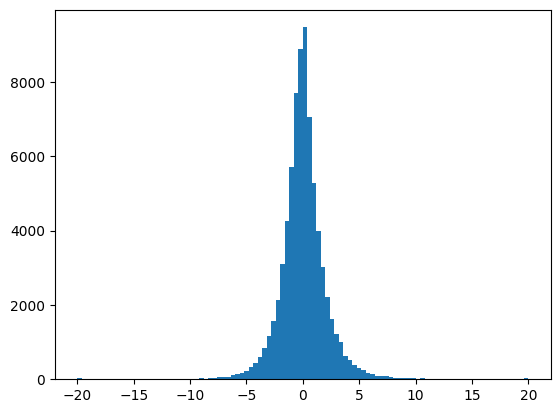

In [16]:
# plt.xlim(-1000, 1000)
plt.hist(y[(-100.0 < y) & (y < 100.0)], bins=100)

In [17]:
for q in (1.0, 0.999, 0.99, 0.98, 0.95, 0.001, 0.0):
  print(np.quantile(y, q))

20.0
13.952792
6.184972
4.8295474
3.299723
-14.981824
-20.0


In [18]:
# Train/Validation split
def train_val_split(X: np.ndarray, y: np.ndarray, val_split: float = 0.2, shuffle: bool = True) -> Tuple:
    """Split data into train and validation sets."""
    n_samples = len(X)
    n_val = int(n_samples * val_split)

    if shuffle:
        indices = np.random.permutation(n_samples)
        X = X[indices]
        y = y[indices]

    X_train, X_val = X[:-n_val], X[-n_val:]
    y_train, y_val = y[:-n_val], y[-n_val:]

    print(f"Train: {len(X_train)} samples, Val: {len(X_val)} samples")
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = train_val_split(X, y, config.VALIDATION_SPLIT, shuffle=True)

# # Normalize features (fit on training data only)
# scaler_X = StandardScaler()
# # Reshape for scaler: (n_samples * seq_length, n_features)
# n_train, seq_len, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(-1, n_features)
# X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
# X_train = X_train_scaled.reshape(n_train, seq_len, n_features)

# # Transform validation data
# n_val, _, _ = X_val.shape
# X_val_reshaped = X_val.reshape(-1, n_features)
# X_val_scaled = scaler_X.transform(X_val_reshaped)
# X_val = X_val_scaled.reshape(n_val, seq_len, n_features)

print(f"\nAfter normalization:")
print(f"Train X - Mean: {X_train.mean():.4f}, Std: {X_train.std():.4f}")
print(f"Val X - Mean: {X_val.mean():.4f}, Std: {X_val.std():.4f}")


Train: 60638 samples, Val: 15159 samples

After normalization:
Train X - Mean: 0.0813, Std: 1.5911
Val X - Mean: 0.0813, Std: 1.6009


## Dataset and Model Classes (Modular Architecture)


In [19]:
class StockSequenceDataset(Dataset):
    """
    PyTorch Dataset for stock sequences.
    Modular design allows easy extension for additional features.
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Args:
            X: Input sequences of shape (n_samples, sequence_length, n_features)
            y: Target values of shape (n_samples,)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = StockSequenceDataset(X_train, y_train)
val_dataset = StockSequenceDataset(X_val, y_val)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 948, Val batches: 237


In [20]:
class LSTMModel(nn.Module):
    """
    LSTM model for time series forecasting.
    Modular architecture allows easy extension (e.g., attention, multiple outputs).
    """
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        dropout: float = 0.2,
        bidirectional: bool = False
    ):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional,
            batch_first=True
        )

        # Calculate LSTM output size
        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size

        # Fully connected layers
        self.fc1 = nn.Linear(lstm_output_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)  # Single output for regression

        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            output: Tensor of shape (batch_size, 1)
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)

        # Use the last output (many-to-one architecture)
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Fully connected layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out.squeeze(-1)  # (batch_size,)


# Initialize model with company-specific sentiment
n_features = X_train.shape[2]  # Should be 2: Close_Return and Company_Sentiment
print(f"Number of input features: {n_features} (expected: 2 for Close_Return and Company_Sentiment)")

model = LSTMModel(  # <--- CORRECTED LINE
    input_size=n_features,
    hidden_size=config.HIDDEN_SIZE,
    num_layers=config.NUM_LAYERS,
    dropout=config.DROPOUT,
    bidirectional=config.BIDIRECTIONAL
).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized on {config.DEVICE}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Model architecture summary
print("\nModel architecture:")
print(model)


Number of input features: 2 (expected: 2 for Close_Return and Company_Sentiment)
Model initialized on cuda
Total parameters: 216,321
Trainable parameters: 216,321

Model architecture:
LSTMModel(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


## Training and Validation


In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Trainer:
    """
    Modular trainer class for LSTM model.
    Handles training loop, validation, early stopping, and metrics tracking.
    Now includes checkpointing functionality.
    """
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: optim.Optimizer,
        criterion: nn.Module,
        device: torch.device,
        model_name: str = "lstm_model",
        early_stopping_patience: int = 10
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model_name = model_name
        self.early_stopping_patience = early_stopping_patience

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_model_state = None

        # Create checkpoint directory if it doesn't exist
        self.checkpoint_dir = "checkpoints"
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        # Path to the model checkpoint
        self.checkpoint_path = os.path.join(self.checkpoint_dir, f"{self.model_name}_best.pt")

    def train_epoch(self) -> float:
        """Train for one epoch and return average loss."""
        self.model.train()
        total_loss = 0.0
        n_batches = 0

        for batch_X, batch_y in self.train_loader:
            batch_X = batch_X.to(self.device)
            batch_y = batch_y.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(batch_X)
            loss = self.criterion(predictions, batch_y)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        return total_loss / n_batches

    def validate(self) -> float:
        """Validate and return average loss."""
        self.model.eval()
        total_loss = 0.0
        n_batches = 0

        with torch.no_grad():
            for batch_X, batch_y in self.val_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                predictions = self.model(batch_X)
                loss = self.criterion(predictions, batch_y)

                total_loss += loss.item()
                n_batches += 1

        return total_loss / n_batches

    def save_checkpoint(self, is_best: bool, epoch: int, val_loss: float):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

        # Save the latest checkpoint
        torch.save(checkpoint, os.path.join(self.checkpoint_dir, f"{self.model_name}_latest.pt"))

        # Save the best checkpoint if this is the best model
        if is_best:
            torch.save(checkpoint, self.checkpoint_path)
            print(f"New best model saved with validation loss: {val_loss:.6f}")

    def load_checkpoint(self):
        """Load model checkpoint if it exists."""
        if os.path.exists(self.checkpoint_path):
            print(f"Loading checkpoint from {self.checkpoint_path}")
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)

            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_losses = checkpoint.get('train_losses', [])
            self.val_losses = checkpoint.get('val_losses', [])
            self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))

            start_epoch = checkpoint['epoch'] + 1
            print(f"Resuming training from epoch {start_epoch}")
            print(f"Best validation loss so far: {self.best_val_loss:.6f}")
            return start_epoch
        else:
            print("No checkpoint found. Starting training from scratch.")
            return 0

    def train(self, num_epochs: int) -> dict:
        """Main training loop with early stopping and checkpointing."""
        # Try to load a checkpoint if it exists
        start_epoch = self.load_checkpoint()

        print("Starting training...")
        print(f"{'Epoch':<8} {'Train Loss':<15} {'Val Loss':<15} {'Status':<10}")
        print("-" * 50)

        for epoch in range(start_epoch, num_epochs):
            train_loss = self.train_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            # Early stopping check
            is_best = False
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
                is_best = True
                status = "Improved"
            else:
                self.patience_counter += 1
                status = f"Patience {self.patience_counter}/{self.early_stopping_patience}"

            # Save checkpoint if this is the best model
            if is_best:
                self.save_checkpoint(is_best, epoch, val_loss)

            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"{epoch+1:<8} {train_loss:<15.6f} {val_loss:<15.6f} {status:<10}")

            if self.patience_counter >= self.early_stopping_patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}")
                break

        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)

        print(f"\nTraining completed. Best validation loss: {self.best_val_loss:.6f}")

        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss
        }

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
criterion = nn.MSELoss()

# Create trainer with model name
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=config.DEVICE,
    model_name=f"lstm_sentiment_smaller_data_lmbd{LAMBDA}",  # Specify your model name here
    early_stopping_patience=config.EARLY_STOPPING_PATIENCE
)

# Train model
history = trainer.train(config.NUM_EPOCHS)

No checkpoint found. Starting training from scratch.
Starting training...
Epoch    Train Loss      Val Loss        Status    
--------------------------------------------------
New best model saved with validation loss: 5.108218
1        4.756279        5.108218        Improved  
New best model saved with validation loss: 5.106792
New best model saved with validation loss: 5.106295
5        4.737192        5.106295        Improved  
10       4.746630        5.107437        Patience 5/10
New best model saved with validation loss: 5.081488
New best model saved with validation loss: 5.028472
New best model saved with validation loss: 5.009064
15       4.683885        5.027897        Patience 1/10
New best model saved with validation loss: 4.978129
New best model saved with validation loss: 4.954024
New best model saved with validation loss: 4.938635
New best model saved with validation loss: 4.924358
20       4.550322        4.924358        Improved  
New best model saved with validation 

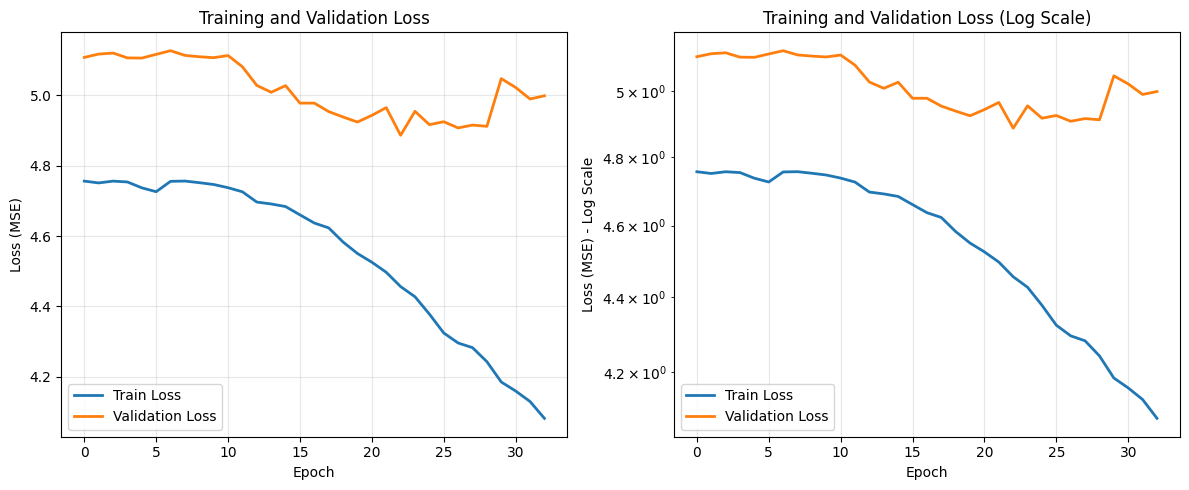

In [22]:
# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Train Loss', linewidth=2)
plt.plot(history['val_losses'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE) - Log Scale')
plt.title('Training and Validation Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Model Evaluation


In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE (Mean Absolute Percentage Error)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by filtering out zero values in y_true
    mask = y_true != 0
    if np.sum(mask) == 0:
        # If all values are zero, return 0 to avoid division by zero
        return 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_model(model: nn.Module, data_loader: DataLoader, device: torch.device) -> dict:
    """Evaluate model and return metrics."""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            predictions = model(batch_X)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.numpy())

    predictions = np.array(all_predictions)
    targets = np.array(all_targets)

    # Calculate metrics
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    mape = mean_absolute_percentage_error(targets, predictions)

    # Calculate directional accuracy (sign prediction)
    pred_sign = np.sign(predictions)
    target_sign = np.sign(targets)
    directional_accuracy = (pred_sign == target_sign).mean() * 100

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'directional_accuracy': directional_accuracy,
        'predictions': predictions,
        'targets': targets
    }

# Evaluate on train and validation sets
print("Evaluating model...")
train_metrics = evaluate_model(model, train_loader, config.DEVICE)
val_metrics = evaluate_model(model, val_loader, config.DEVICE)

print("\n" + "="*50)
print("TRAINING SET METRICS")
print("="*50)
print(f"MSE:  {train_metrics['mse']:.6f}")
print(f"RMSE: {train_metrics['rmse']:.6f}")
print(f"MAE:  {train_metrics['mae']:.6f}")
print(f"MAPE: {train_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {train_metrics['directional_accuracy']:.2f}%")

print("\n" + "="*50)
print("VALIDATION SET METRICS")
print("="*50)
print(f"MSE:  {val_metrics['mse']:.6f}")
print(f"RMSE: {val_metrics['rmse']:.6f}")
print(f"MAE:  {val_metrics['mae']:.6f}")
print(f"MAPE: {val_metrics['mape']:.2f}%")
print(f"Directional Accuracy: {val_metrics['directional_accuracy']:.2f}%")

Evaluating model...

TRAINING SET METRICS
MSE:  3.961660
RMSE: 1.990392
MAE:  1.370061
MAPE: 113.22%
Directional Accuracy: 51.18%

VALIDATION SET METRICS
MSE:  4.998508
RMSE: 2.235734
MAE:  1.452934
MAPE: 118.90%
Directional Accuracy: 50.66%


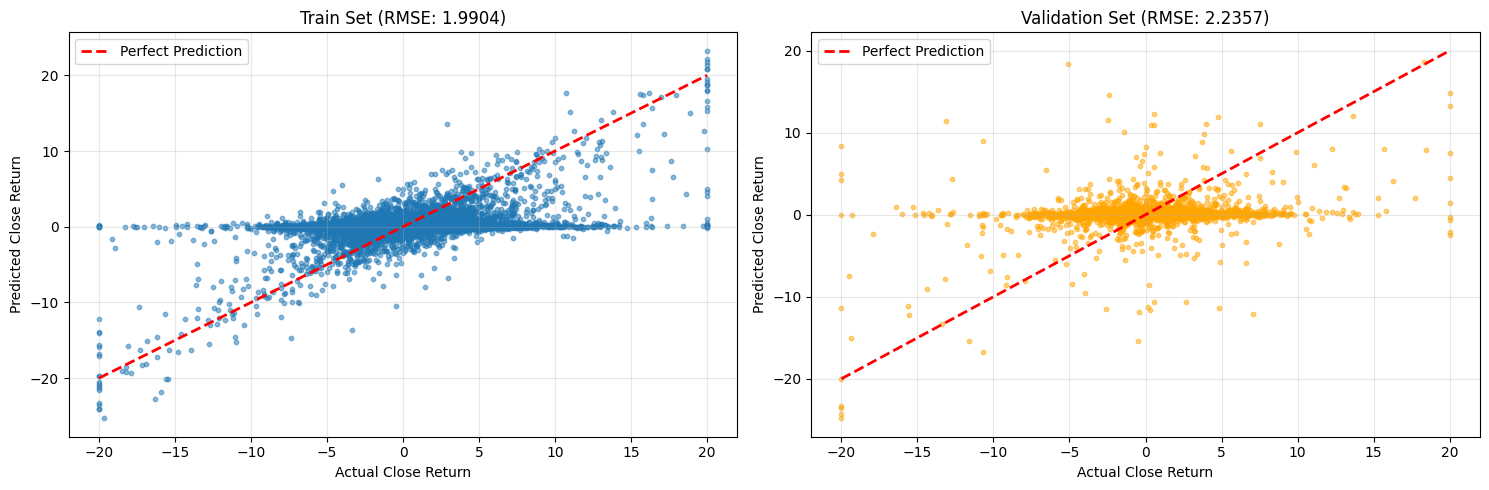

In [24]:
# Plot predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(train_metrics['targets'], train_metrics['predictions'], alpha=0.5, s=10)
axes[0].plot([train_metrics['targets'].min(), train_metrics['targets'].max()],
              [train_metrics['targets'].min(), train_metrics['targets'].max()],
              'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Close Return')
axes[0].set_ylabel('Predicted Close Return')
axes[0].set_title(f'Train Set (RMSE: {train_metrics["rmse"]:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation set
axes[1].scatter(val_metrics['targets'], val_metrics['predictions'], alpha=0.5, s=10, color='orange')
axes[1].plot([val_metrics['targets'].min(), val_metrics['targets'].max()],
             [val_metrics['targets'].min(), val_metrics['targets'].max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Close Return')
axes[1].set_ylabel('Predicted Close Return')
axes[1].set_title(f'Validation Set (RMSE: {val_metrics["rmse"]:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


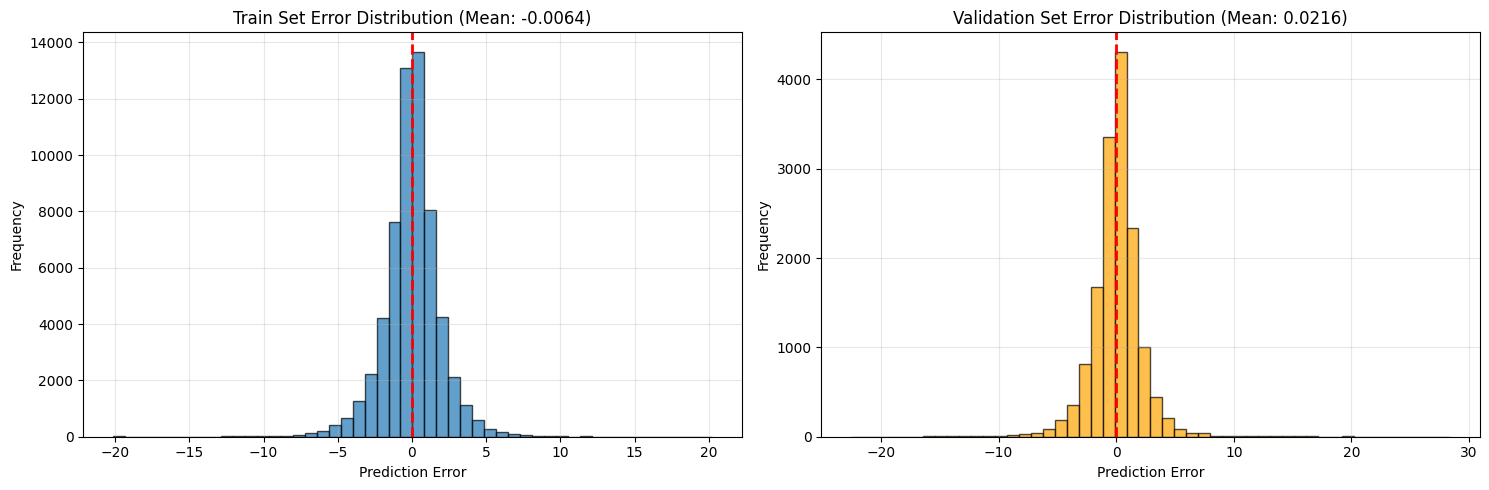

In [25]:
# Plot error distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

train_errors = train_metrics['predictions'] - train_metrics['targets']
val_errors = val_metrics['predictions'] - val_metrics['targets']

axes[0].hist(train_errors, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Prediction Error')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Set Error Distribution (Mean: {train_errors.mean():.4f})')
axes[0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

axes[1].hist(val_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Prediction Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Validation Set Error Distribution (Mean: {val_errors.mean():.4f})')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
